In [ ]:
pip install spotipy

# Playlist Analysis

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

id = '627414d9842a40a9941c69152d1ef5d4'
secret = '9b1249549b214a9e9bd26f45cda8f44a'

auth_manager = SpotifyClientCredentials(client_id=id, client_secret=secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [ ]:
def get_playlist_tracks(username, playlist_id):
  results = sp.user_playlist_tracks(username, playlist_id)
  tracks = results['items']
  while results['next']:
    results = sp.next(results)
    tracks.extend(results['items'])
  return tracks

tracks = get_playlist_tracks("timo1701", "09PpyE5sNUzEduVcpFyjwH")

In [ ]:
def get_tracks_features(tracks):
  features = []

  for i, t in enumerate(tracks):
    id = t["track"]["id"]
    feature = sp.audio_features(id)
    features.extend(feature)

    if i%100  == 0:
      print(i)

  return features

features = get_tracks_features(tracks)

Let's save those information.

In [ ]:
import json

def save_features(name, features):
  with open(name + ".json", 'w', encoding='utf-8') as file:
    json.dump(features, file)

def load_features(name):
  with open(name + ".json", "r") as file:
    features = json.load(file)
  return features

In [ ]:
import matplotlib.pyplot as plt

def feature_hist(ax, name, features, bins):
  feature = [item[name] for item in features]
  ax.hist(feature, bins=bins)
  ax.title.set_text(name)

fig, axs = plt.subplots(4, 2, figsize=(16, 16))

'''
feature_hist(axs[0, 0], "danceability", features, 30, (0.0, 1.0))
feature_hist(axs[0, 1], "energy", features, 30, (0.0, 1.0))

feature_hist(axs[1, 0], "loudness", features, 30, (0.0, 1.0))
feature_hist(axs[1, 1], "speechiness", features, 30, (0.0, 1.0))

feature_hist(axs[2, 0], "acousticness", features, 30)
feature_hist(axs[2, 1], "instrumentalness", features, 30)

feature_hist(axs[3, 0], "liveness", features, 30)
feature_hist(axs[3, 1], "valence", features, 30)
'''

So what does that learn us? Not much really, we need to compare to others playlists. Let's take those made by spotify.

In [ ]:
#classical enssentials
classic_tracks = get_playlist_tracks("timo1701", "37i9dQZF1DWWEJlAGA9gs0")
classic_features = get_tracks_features(classic_tracks)

0
100


In [ ]:
#rock classics
rock_tracks = get_playlist_tracks("timo1701", "37i9dQZF1DWXRqgorJj26U")
rock_features = get_tracks_features(rock_tracks)

0
100


In [ ]:
#heavy metal
metal_tracks = get_playlist_tracks("timo1701", "37i9dQZF1DX9qNs32fujYe")
metal_features = get_tracks_features(metal_tracks)

0
100


In [ ]:
#jazz classics
jazz_tracks = get_playlist_tracks("timo1701", "37i9dQZF1DXbITWG1ZJKYt")
jazz_features = get_tracks_features(jazz_tracks)

0
100


TypeError: ignored

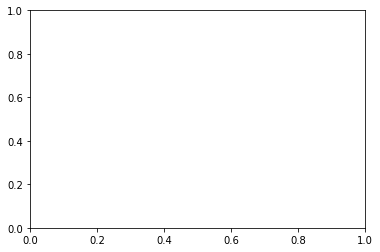

In [ ]:
fig, ax = plt.subplot()

feature_hist(ax, "danceability", classic_features, 10)
feature_hist(ax, "danceability", rock_features, 10)
feature_hist(ax, "danceability", metal_features, 10)
feature_hist(ax, "danceability", jazz_features, 10)

# Data Analysis

In [108]:
import json
import matplotlib.pyplot as plt

def getData(path, n):
  data = []
  for i in range(n):
    name = path + "StreamingHistory" + str(i) + ".json"
    with open(name) as f:
      data += json.load(f)
  return data

def getTime(data):
  time = []
  for item in data:
      t = item['endTime']
      t = datetime.strptime(t, '%Y-%m-%d %H:%M')
      time.append(t)
  return time

data = getData("/content/", 4)
time = getTime(data)

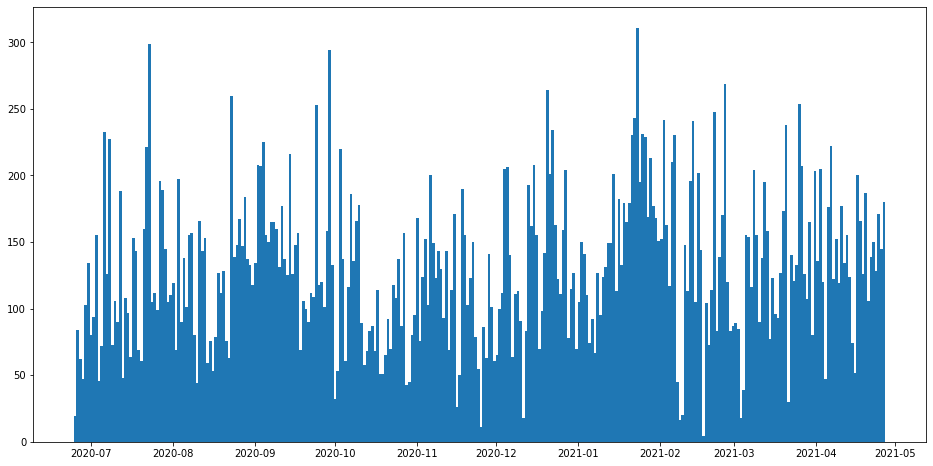

In [109]:
from datetime import datetime, timedelta

def plotDailyStreamingHistory(time):
  start = time[0]
  end = time[-1]
  delta = (end - start).days

  # plot it
  fig, ax = plt.subplots(figsize=(16, 8))
  ax.hist(time, bins=delta)
  locator = mdates.AutoDateLocator()
  ax.xaxis.set_major_locator(locator)
  ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
  plt.show()

plotDailyStreamingHistory(time)

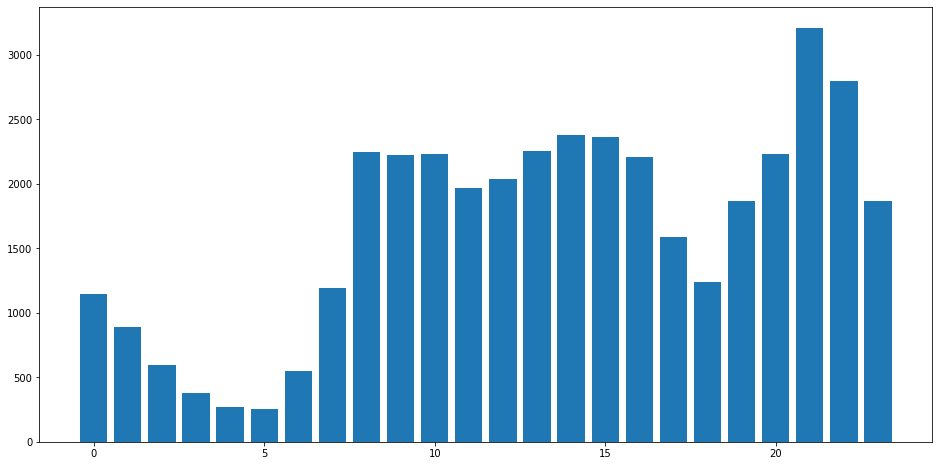

In [110]:
def plotHourlyStreamingHistory(time):
  hours = [0 for y in range(24)]
  y = [y for y in range(24)]
  
  for t in time:
    hours[t.hour] += 1
  
  fig, ax = plt.subplots(figsize=(16, 8))
  ax.bar(y, hours)
  plt.show()

plotHourlyStreamingHistory(time)

Let's look at my most popular songs and many times I've played them.

In [132]:
# count = {'count':, 'artistName': , 'trackName': , 'msPlayed':}

def countSongOccurrences(time):
  occurences = []

  while len(time) > 0:
    artistName = time[-1]["artistName"]
    trackName = time[-1]["trackName"]
    msPlayed = 0
    count = 0
    
    for i in reversed(range(len(time))):
      if time[i]["artistName"] == artistName:
        count += 1
        msPlayed += time[i]["msPlayed"]
        time.pop(i)

    minPlayed = int(msPlayed / (1000 * 60))
    occurence = {'count': count, 'artistName': artistName, 'trackName': trackName, "minPlayed": minPlayed}
    occurences.append(occurence)

  return occurences

data = getData("/content/", 4)
occurences = countSongOccurrences(data)

In [133]:
favorite = sorted(occurences, key=lambda x: x['count'], reverse=True) 

for i in range(10):
  print(favorite[i])

{'count': 1393, 'artistName': 'The Districts', 'trackName': 'Funeral Beds', 'minPlayed': 5255}
{'count': 1368, 'artistName': 'Machine Gun Kelly', 'trackName': 'Alpha Omega', 'minPlayed': 3013}
{'count': 801, 'artistName': 'grandson', 'trackName': 'Despicable', 'minPlayed': 2234}
{'count': 696, 'artistName': 'Supertramp', 'trackName': 'Waiting So Long', 'minPlayed': 2999}
{'count': 671, 'artistName': 'Robin Schulz', 'trackName': 'Wrong - Radio Mix', 'minPlayed': 2104}
{'count': 564, 'artistName': 'EDEN', 'trackName': 'End Credits', 'minPlayed': 2029}
{'count': 521, 'artistName': 'NF', 'trackName': 'Let You Down', 'minPlayed': 1726}
{'count': 515, 'artistName': 'French 79', 'trackName': 'Olympic', 'minPlayed': 1908}
{'count': 508, 'artistName': 'Oh Wonder', 'trackName': 'Better Now', 'minPlayed': 1625}
{'count': 490, 'artistName': 'Imagine Dragons', 'trackName': 'Whatever It Takes', 'minPlayed': 1226}
